In [2]:
%pip install pyodbc
%pip install pandas
%pip install pyarrow
%pip install pillow
%pip install ipython


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
from PIL import Image
from IPython.display import display
import os
import shutil

1ª Parte – Desenvolvimento Pipeline/Notebook Visual Code


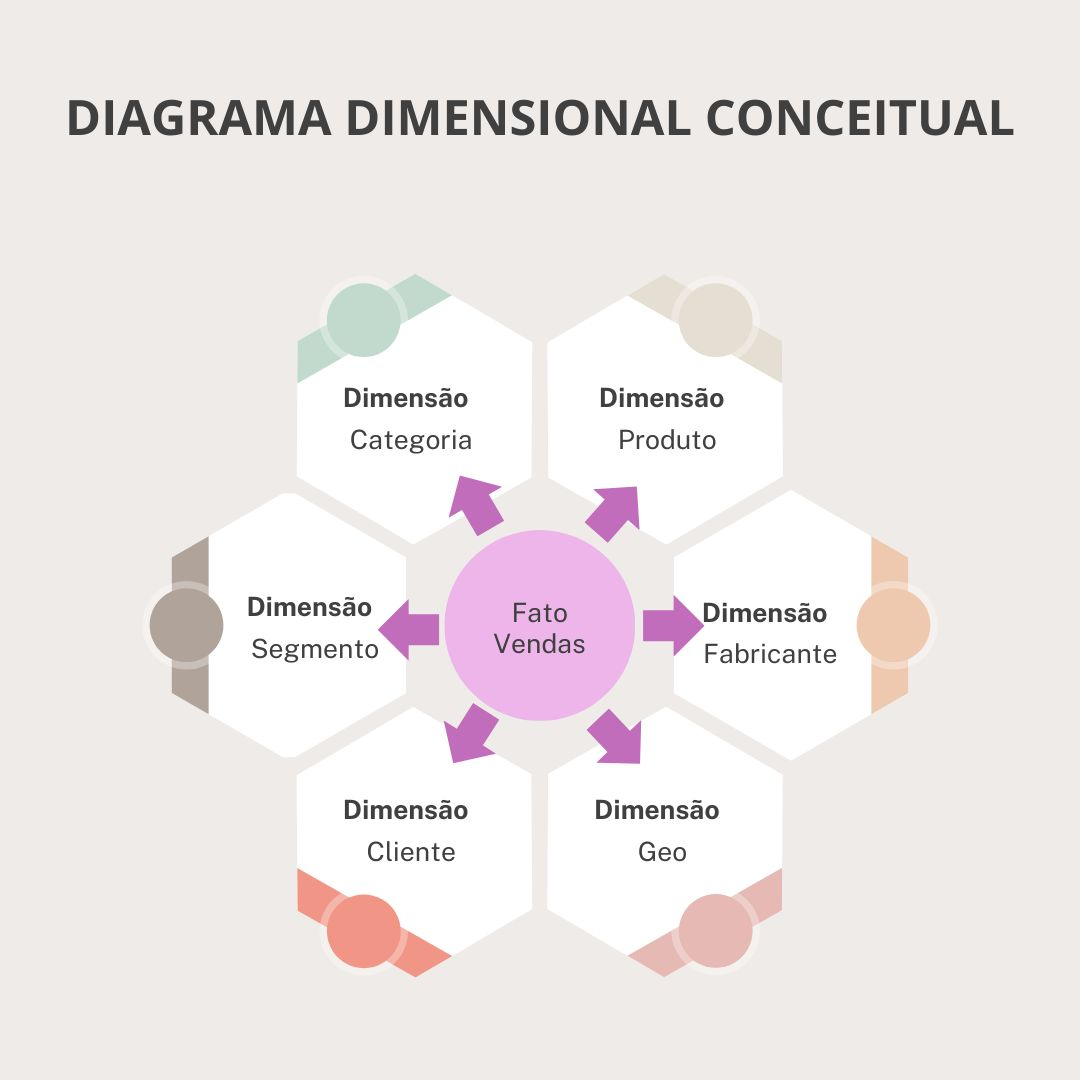

In [5]:
####Gere um diagrama dimensional conceitual com a modelagem aplicada

# Carregar a imagem DIAGRAMA DIMENSIONAL CONCEITUAL
imagem = Image.open("C:\DWE_LAKEHOUSE - SCD1\diagramaconceitual.jpg")

# Exibir a imagem
display(imagem)


In [6]:
#### CAMADA BRONZE: Contém o arquivo disponibilizado;

# Carregue o arquivo vendas.csv
df = pd.read_csv("C:\\DWE_LAKEHOUSE - SCD1\\BRONZE\\vendas.csv")

# Escrevendo o DataFrame em um arquivo CSV
df.to_csv("C:\\DWE_LAKEHOUSE - SCD1\\BRONZE\\vendas.csv", index=False)

# Exibindo o DataFrame
print(df)

        IDProduto                     Data  IDCliente  IDCampanha  Unidades  \
0             449  2012-07-26 00:00:00.000     247546          22         1   
1             449  2013-10-31 00:00:00.000     124593          22         1   
2             449  2013-11-14 00:00:00.000     163517          22         1   
3             449  2013-01-17 00:00:00.000       8875          18         1   
4             449  2014-09-13 00:00:00.000       8894          21         1   
...           ...                      ...        ...         ...       ...   
675363        407  2012-05-20 00:00:00.000      32464           3         1   
675364        407  2011-03-02 00:00:00.000      32441           5         1   
675365        407  2012-06-02 00:00:00.000     101533           1         1   
675366        407  2011-04-10 00:00:00.000     147192           4         1   
675367        407  2012-03-01 00:00:00.000     237766           3         1   

              Produto  Categoria    Segmento  IDFab

In [7]:
#### CAMADA SILVER -> Contém arquivos transformados em formato parquet; 
# Tratar a coluna nome, separando e-mail de nome
# Tratar a coluna cidade, mantendo apenas o nome da cidade.
# Eliminar as colunas IDCampanha, distrito e código postal. 
# Foi tratado também a coluna Data

# Lendo o arquivo vendas.csv 
df = pd.read_csv("C:\\DWE_LAKEHOUSE - SCD1\\BRONZE\\vendas.csv").infer_objects()

# Separe o e-mail do nome na coluna "EmailNome"
df[['Email', 'Nome']] = df['EmailNome'].str.split(':', expand=True)

# Pegando o conteúdo dentro do parênteses
df['Email'] = df['Email'].str.extract(r'\((.*?)\)')

# Exibindo o DataFrame resultante
#print(df['Email'])

# Mantenha apenas o nome da cidade na coluna "Cidade"
df['Cidade'] = df['Cidade'].str.split(',').str[0]

# Exibindo o DataFrame resultante
#print(df['Cidade'])

# Elimine as colunas não necessárias
df.drop(columns=['IDCampanha', 'Distrito', 'CodigoPostal', 'EmailNome'], inplace=True)

# Extrair apenas a parte da data '2012-03-01'
df['Data'] = pd.to_datetime(df['Data']).dt.date

# Converta data para tipo datetime
df['Data'] = pd.to_datetime(df['Data'], format='%Y-%m-%d')
df["Ano"] = df["Data"].dt.year
df["Mes"] = df["Data"].dt.month

# Exibindo o DataFrame resultante
print(df)

# Salva o arquivo parquet com o DataFrame na camada SILVER
df.to_parquet("C:\\DWE_LAKEHOUSE - SCD1\\SILVER\\vendas_transformadas.parquet", index=False)


        IDProduto       Data  IDCliente  Unidades        Produto  Categoria  \
0             449 2012-07-26     247546         1  Maximus UM-54      Urban   
1             449 2013-10-31     124593         1  Maximus UM-54      Urban   
2             449 2013-11-14     163517         1  Maximus UM-54      Urban   
3             449 2013-01-17       8875         1  Maximus UM-54      Urban   
4             449 2014-09-13       8894         1  Maximus UM-54      Urban   
...           ...        ...        ...       ...            ...        ...   
675363        407 2012-05-20      32464         1  Maximus UM-12  Accessory   
675364        407 2011-03-02      32441         1  Maximus UM-12  Accessory   
675365        407 2012-06-02     101533         1  Maximus UM-12  Accessory   
675366        407 2011-04-10     147192         1  Maximus UM-12  Accessory   
675367        407 2012-03-01     237766         1  Maximus UM-12  Accessory   

          Segmento  IDFabricante Fabricante  CustoU

In [8]:
#### CAMADA GOLD: Contém os arquivos prontos para uso em formato parquet;
#Adicionar as SK´s as tabelas dimensões.
# Aplicar SCD1 nas dimensões.
# Adicionar as SK´s tabela fato.
# Particionar os arquivos Parquet da tabela fato em ano e mês

In [9]:
#Se essa opção for igual a True, refazemos todas as dimensões e a fato.
# Se for False é para cargas incrementais tanto das dimensões e fato. (apendar)
reproc = True

In [10]:
#Métodos utilitários para fazer o reprocessamento da dimensões e fato
import os

def deletar_arquivos_diretorio(caminho):
    try:
        for arquivo in os.listdir(caminho):
            caminho_completo = os.path.join(caminho, arquivo)
            if os.path.isfile(caminho_completo):
                os.remove(caminho_completo)
                print(f"Arquivo {caminho_completo} removido com sucesso.")
    except FileNotFoundError:
        print(f"O diretório {caminho} não existe.")


def deletar_pastas_recursivamente(caminho):
    try:
        for raiz, diretorios, arquivos in os.walk(caminho):
            for diretorio in diretorios:
                caminho_completo = os.path.join(raiz, diretorio)
                shutil.rmtree(caminho_completo)
                print(f"Diretório {caminho_completo} removido com sucesso.")
    except FileNotFoundError:
        print(f"O diretório {caminho} não existe.")


def write(df, path_dim, reproc):
    table = pa.Table.from_pandas(df)

    if reproc:
        print("reproc")
        deletar_arquivos_diretorio(path_dim)
        pq.write_to_dataset(table, root_path=path_dim)
    else:
        print("no reproc")
        pq.write_to_dataset(table, root_path=path_dim)

def write_partitioned(df, path, cols, reproc):
    table = pa.Table.from_pandas(df)

    if reproc:
        print("reproc")
        deletar_pastas_recursivamente(path)
        pq.write_to_dataset(table, root_path=path, partition_cols=cols)
    else:
        print("no reproc")
        pq.write_to_dataset(table, root_path=path, partition_cols=cols)


In [11]:
# Lê os dados do arquivo Parquet
df = pd.read_parquet("C:\\DWE_LAKEHOUSE - SCD1\\SILVER\\vendas_transformadas.parquet")
df

,IDProduto,Data,IDCliente,Unidades,Produto,Categoria,Segmento,IDFabricante,Fabricante,CustoUnitario,PrecoUnitario,Cidade,Estado,Regiao,Pais,Email,Nome,Ano,Mes
0,449,2012-07-26,247546,1,Maximus UM-54,Urban,Moderation,7,VanArsdel,74.729917,102.36975,Miami,FL,East,USA,Nerea.Barry@xyza.com,"Barry, Nerea",2012,7
1,449,2013-10-31,124593,1,Maximus UM-54,Urban,Moderation,7,VanArsdel,74.729917,102.36975,Miami,FL,East,USA,Elliott.Stuart@xyza.com,"Stuart, Elliott",2013,10
2,449,2013-11-14,163517,1,Maximus UM-54,Urban,Moderation,7,VanArsdel,74.729917,102.36975,Miami,FL,East,USA,Holmes.Swanson@xyza.com,"Swanson, Holmes",2013,11
3,449,2013-01-17,8875,1,Maximus UM-54,Urban,Moderation,7,VanArsdel,74.729917,102.36975,Miami,FL,East,USA,Nyssa.Solis@xyza.com,"Solis, Nyssa",2013,1
4,449,2014-09-13,8894,1,Maximus UM-54,Urban,Moderation,7,VanArsdel,74.729917,102.36975,Miami,FL,East,USA,Ivana.Wall@xyza.com,"Wall, Ivana",2014,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
675363,407,2012-05-20,32464,1,Maximus UM-12,Accessory,Accessory,7,VanArsdel,116.887417,160.11975,Panama City,FL,East,USA,Catherine.Martinez@xyza.com,"Martinez, Catherine",2012,5
675364,407,2011-03-02,32441,1,Maximus UM-12,Accessory,Accessory,7,VanArsdel,116.887417,160.11975,Panama City,FL,East,USA,Dora.Emerson@xyza.com,"Emerson, Dora",2011,3
675365,407,2012-06-02,101533,1,Maximus UM-12,Accessory,Accessory,7,VanArsdel,116.887417,160.11975,Pensacola,FL,East,USA,Lynn.Jones@xyza.com,"Jones, Lynn",2012,6
675366,407,2011-04-10,147192,1,Maximus UM-12,Accessory,Accessory,7,VanArsdel,116.887417,160.11975,Panama City Beach,FL,East,USA,Maite.Cantrell@xyza.com,"Cantrell, Maite",2011,4


In [12]:
####DIMENSÃO PRODUTO####
path_dim = "C:\DWE_LAKEHOUSE - SCD1\GOLD\dimensao_vendas\produto"

df_temp = df[["IDProduto", "Produto"]].drop_duplicates(subset=["IDProduto"])

#Pega o ultimo valor de sk atribuido
dimensao_produto = pd.read_parquet(path_dim)
if not dimensao_produto.empty:
    id_sk_max = dimensao_produto['SK_Produto'].max()

# Criar o novo dataframe com ID auto-incrementável
if reproc:
    df_d_produto = pd.DataFrame(columns=["SK_Produto", "IDProduto", "Produto"])
    current_id = 1
    for index, row in df_temp.iterrows():
        temp_df = pd.DataFrame({
            "SK_Produto": [current_id],
            "IDProduto": [row["IDProduto"]],
            "Produto": [row["Produto"]]        
        })
        df_d_produto = pd.concat([df_d_produto, temp_df])
        current_id += 1
else:
    dimensao_produto = dimensao_produto[['SK_Produto', "IDProduto"]]
    produto = dimensao_produto.merge(df_temp, on='IDProduto', how='outer')
    valores_nulos = produto[produto['SK_Produto'].isnull()]

    df_d_produto = pd.DataFrame(columns=["SK_Produto", "IDProduto", "Produto"])
    current_id = id_sk_max + 1
    for index, row in valores_nulos.iterrows():
        temp_df = pd.DataFrame({
            "SK_Produto": [current_id],
            "IDProduto": [row["IDProduto"]],
            "Produto": [row["Produto"]]      
        })
        df_d_produto = pd.concat([df_d_produto, temp_df])
        current_id += 1

#Exibir o novo dataframe
if not df_d_produto.empty:
    write(df_d_produto, path_dim=path_dim, reproc=reproc)

dim = pd.read_parquet('C:\DWE_LAKEHOUSE - SCD1\GOLD\dimensao_vendas\produto')
dim

reproc
Arquivo C:\DWE_LAKEHOUSE - SCD1\GOLD\dimensao_vendas\produto\932b2c1db41e40babf0da3757e84b7b2-0.parquet removido com sucesso.


,SK_Produto,IDProduto,Produto
0,1,449,Maximus UM-54
0,2,470,Maximus UM-75
0,3,496,Maximus UM-01
0,4,457,Maximus UM-62
0,5,433,Maximus UM-38
...,...,...,...
0,208,398,Maximus UM-03
0,209,405,Maximus UM-10
0,210,406,Maximus UM-11
0,211,402,Maximus UM-07


In [13]:
####DIMENSÃO CATEGORIA####
path_dim = "C:\DWE_LAKEHOUSE - SCD1\GOLD\dimensao_vendas\categoria"

#Le o dataframe do csv para pegar as novas categorias
df_temp = df[["Categoria"]].drop_duplicates(subset=["Categoria"])

#Pega o ultimo valor de sk atribuido
dimensao_categoria = pd.read_parquet(path_dim)
if not dimensao_categoria.empty:
    id_sk_max = dimensao_categoria['SK_Categoria'].max()

#Criar o novo dataframe com ID auto-incrementável
if reproc:
    df_d_categoria = pd.DataFrame(columns=["SK_Categoria", "Categoria"])
    current_id = 1
    for index, row in df_temp.iterrows():
        temp_df = pd.DataFrame({
            "SK_Categoria": [current_id],        
            "Categoria": [row["Categoria"]],        
        })
        df_d_categoria = pd.concat([df_d_categoria, temp_df])
        current_id += 1
else:
    categoria = dimensao_categoria.merge(df_temp, on='Categoria', how='outer')
    valores_nulos = categoria[categoria['SK_Categoria'].isnull()]

    df_d_categoria = pd.DataFrame(columns=["SK_Categoria", "Categoria"])
    current_id = id_sk_max + 1
    for index, row in valores_nulos.iterrows():
        temp_df = pd.DataFrame({
            "SK_Categoria": [current_id],        
            "Categoria": [row["Categoria"]],        
        })
        df_d_categoria = pd.concat([df_d_categoria, temp_df])
        current_id += 1

#Exibir o novo dataframe
if not df_d_categoria.empty:
    write(df_d_categoria, path_dim=path_dim, reproc=reproc)

dim = pd.read_parquet('C:\DWE_LAKEHOUSE - SCD1\GOLD\dimensao_vendas\categoria')
dim

reproc
Arquivo C:\DWE_LAKEHOUSE - SCD1\GOLD\dimensao_vendas\categoria\5ec8fdaea59044ebad0032b7358d07d9-0.parquet removido com sucesso.


,SK_Categoria,Categoria
0,1,Urban
0,2,Mix
0,3,Youth
0,4,Rural
0,5,Accessory


In [14]:
####DIMENSÃO SEGMENTO####
path_dim = "C:\DWE_LAKEHOUSE - SCD1\GOLD\dimensao_vendas\segmento"

df_temp = df[["Segmento"]].drop_duplicates(subset=["Segmento"])

#Pega o ultimo valor de sk atribuido
dimensao_segmento = pd.read_parquet(path_dim)
if not dimensao_segmento.empty:
    id_sk_max = dimensao_segmento['SK_Segmento'].max()

# Criar o novo dataframe com ID auto-incrementável
if reproc:
    df_d_segmento = pd.DataFrame(columns=["SK_Segmento", "Segmento"])
    current_id = 1
    for index, row in df_temp.iterrows():
        temp_df = pd.DataFrame({
            "SK_Segmento": [current_id],        
            "Segmento": [row["Segmento"]],        
        })
        df_d_segmento = pd.concat([df_d_segmento, temp_df])
        current_id += 1
else:
    segmento = dimensao_segmento.merge(df_temp, on='Segmento', how='outer')
    valores_nulos = segmento[segmento['SK_Segmento'].isnull()]

    df_d_segmento = pd.DataFrame(columns=["SK_Segmento", "Segmento"])
    current_id = id_sk_max + 1
    for index, row in valores_nulos.iterrows():
        temp_df = pd.DataFrame({
            "SK_Segmento": [current_id],        
            "Segmento": [row["Segmento"]],        
        })
        df_d_segmento = pd.concat([df_d_segmento, temp_df])
        current_id += 1

# Salve os dados da dimensão Produto com a coluna SK_Produto na camada GOLD
if not df_d_segmento.empty:
    write(df_d_segmento, path_dim=path_dim, reproc=reproc)

dim = pd.read_parquet('C:\DWE_LAKEHOUSE - SCD1\GOLD\dimensao_vendas\segmento')
dim

reproc
Arquivo C:\DWE_LAKEHOUSE - SCD1\GOLD\dimensao_vendas\segmento\cf18308648c843619e3c747fe4f5d3b2-0.parquet removido com sucesso.


,SK_Segmento,Segmento
0,1,Moderation
0,2,Convenience
0,3,Extreme
0,4,Regular
0,5,All Season
0,6,Productivity
0,7,Youth
0,8,Select
0,9,Accessory


In [17]:
####DIMENSÃO CLIENTE####
path_dim = "C:\DWE_LAKEHOUSE - SCD1\GOLD\dimensao_vendas\cliente"

df_temp = df[["IDCliente", "Email", "Nome"]].drop_duplicates(subset=["IDCliente"])

#Pega o ultimo valor de sk atribuido
dimensao_cliente = pd.read_parquet(path_dim)
if not dimensao_cliente.empty:
    id_sk_max = dimensao_cliente['SK_Cliente'].max()

# Criar o novo dataframe com ID auto-incrementável (Primeiro foi criada a lista e populada todas as linhas e no final criado o dataframe p/ conseguir uma melhor performance)
list_of_cliente = []

#reproc (reprocessamento de tudo - se for true)

if reproc:
    current_id = 1
    for index, row in df_temp.iterrows():
        list_of_cliente.append({
            "SK_Cliente": current_id,
            "IDCliente": row["IDCliente"],
            "Email": row["Email"],
            "Nome": row["Nome"]        
        })
        current_id += 1
    df_d_cliente = pd.DataFrame(list_of_cliente)

# para carregar somente os novos clientes (inputs)  
else:
    cliente = dimensao_cliente[['SK_Cliente', "IDCliente"]]
    cliente = cliente.merge(df_temp, on='IDCliente', how='outer')
    valores_nulos = cliente[cliente['SK_Cliente'].isnull()]

    current_id = id_sk_max + 1

    for index, row in valores_nulos.iterrows():
        list_of_cliente.append({
            "SK_Cliente": current_id,
            "IDCliente": row["IDCliente"],
            "Email": row["Email"],
            "Nome": row["Nome"]      
        })
        current_id += 1
    df_d_cliente = pd.DataFrame(list_of_cliente)

# Salve os dados da dimensão Cliente com a coluna SK_Cliente na camada GOLD
if not df_d_cliente.empty:
    write(df_d_cliente, path_dim=path_dim, reproc=reproc)

dim = pd.read_parquet('C:\DWE_LAKEHOUSE - SCD1\GOLD\dimensao_vendas\cliente')
dim

reproc
Arquivo C:\DWE_LAKEHOUSE - SCD1\GOLD\dimensao_vendas\cliente\46699cca19224c7daf0fcbb8e4b6616b-0.parquet removido com sucesso.


,SK_Cliente,IDCliente,Email,Nome
0,1,247546,Nerea.Barry@xyza.com,"Barry, Nerea"
1,2,124593,Elliott.Stuart@xyza.com,"Stuart, Elliott"
2,3,163517,Holmes.Swanson@xyza.com,"Swanson, Holmes"
3,4,8875,Nyssa.Solis@xyza.com,"Solis, Nyssa"
4,5,8894,Ivana.Wall@xyza.com,"Wall, Ivana"
...,...,...,...,...
282591,282592,274255,Kirestin.Sloan@xyza.com,"Sloan, Kirestin"
282592,282593,106491,Bethany.Mcdaniel@xyza.com,"Mcdaniel, Bethany"
282593,282594,188636,Venus.Floyd@xyza.com,"Floyd, Venus"
282594,282595,203361,Patience.Williams@xyza.com,"Williams, Patience"


In [19]:
####DIMENSÃO FABRICANTE####
path_dim = "C:\DWE_LAKEHOUSE - SCD1\GOLD\dimensao_vendas\\fabricante"

df_temp = df[["IDFabricante", "Fabricante"]].drop_duplicates(subset=["IDFabricante"])

#Pega o ultimo valor de sk atribuido
dimensao_fabricante = pd.read_parquet(path_dim)
if not dimensao_fabricante.empty:
    id_sk_max = dimensao_fabricante['SK_Fabricante'].max()

# Criar o novo dataframe com ID auto-incrementável
if reproc:
    df_d_fabricante = pd.DataFrame(columns=["SK_Fabricante", "IDFabricante", "Fabricante"])
    current_id = 1
    for index, row in df_temp.iterrows():
        temp_df = pd.DataFrame({
            "SK_Fabricante": [current_id],
            "IDFabricante": [row["IDFabricante"]],
            "Fabricante": [row["Fabricante"]]            
        })
        df_d_fabricante = pd.concat([df_d_fabricante, temp_df])
        current_id += 1
else:
    dimensao_fabricante = dimensao_fabricante[['SK_Fabricante', "IDFabricante"]]
    fabricante = dimensao_fabricante.merge(df_temp, on='IDFabricante', how='outer')
    print(fabricante)

    valores_nulos = fabricante[fabricante['SK_Fabricante'].isnull()]

    df_d_fabricante = pd.DataFrame(columns=["SK_Fabricante", "IDFabricante", "Fabricante"])
    current_id = id_sk_max + 1
    for index, row in valores_nulos.iterrows():
        temp_df = pd.DataFrame({
            "SK_Fabricante": [current_id],
            "IDFabricante": [row["IDFabricante"]],
            "Fabricante": [row["Fabricante"]]            
        })
        df_d_fabricante = pd.concat([df_d_fabricante, temp_df])
        current_id += 1

# Salve os dados da dimensão Fabricante com a coluna SK_Fabricante na camada GOLD
if not df_d_fabricante.empty:
    write(df_d_fabricante, path_dim=path_dim, reproc=reproc)

dim = pd.read_parquet(path_dim)
dim

reproc
Arquivo C:\DWE_LAKEHOUSE - SCD1\GOLD\dimensao_vendas\fabricante\bcdcc64576d9483dbb250ac846d5fc72-0.parquet removido com sucesso.


,SK_Fabricante,IDFabricante,Fabricante
0,1,7,VanArsdel


In [20]:
####DIMENSÃO GEO####
path_dim = "C:\DWE_LAKEHOUSE - SCD1\GOLD\dimensao_vendas\\geo"

df_temp = df[["Cidade", "Estado", "Regiao", "Pais"]].drop_duplicates(subset=["Cidade"])

#Pega o ultimo valor de sk atribuido
dimensao_geo = pd.read_parquet(path_dim)
if not dimensao_geo.empty:
    id_sk_max = dimensao_geo['SK_Geo'].max()


# Criar o novo dataframe com ID auto-incrementável
if reproc:
    df_d_geo = pd.DataFrame(columns=["SK_Geo", "Cidade", "Estado", "Regiao", "Pais"])
    current_id = 1
    for index, row in df_temp.iterrows():
        temp_df = pd.DataFrame({
            "SK_Geo": [current_id],
            "Cidade": [row["Cidade"]],
            "Estado": [row["Estado"]], 
            "Regiao": [row["Regiao"]],    
            "Pais": [row["Pais"]]           
        })
        df_d_geo = pd.concat([df_d_geo, temp_df])
        current_id += 1
else:
    dimensao_geo = dimensao_geo[['SK_Geo', "Cidade"]]
    geo = dimensao_geo.merge(df_temp, on='Cidade', how='outer')
    valores_nulos = geo[geo['SK_Geo'].isnull()]
    print(valores_nulos)

    df_d_geo = pd.DataFrame(columns=["SK_Geo", "Cidade", "Estado", "Regiao", "Pais"])
    current_id = id_sk_max + 1
    for index, row in valores_nulos.iterrows():
        temp_df = pd.DataFrame({
            "SK_Geo": [current_id],
            "Cidade": [row["Cidade"]],
            "Estado": [row["Estado"]], 
            "Regiao": [row["Regiao"]],    
            "Pais": [row["Pais"]]           
        })
        df_d_geo = pd.concat([df_d_geo, temp_df])
        current_id += 1

# Salve os dados da dimensão Geo com a coluna SK_Geo na camada GOLD
if not df_d_geo.empty:
    write(df_d_geo, path_dim=path_dim, reproc=reproc)

dim = pd.read_parquet(path_dim)
dim

reproc
Arquivo C:\DWE_LAKEHOUSE - SCD1\GOLD\dimensao_vendas\geo\04960b291d6e4551b904ade41b485106-0.parquet removido com sucesso.


,SK_Geo,Cidade,Estado,Regiao,Pais
0,1,Miami,FL,East,USA
0,2,Fort Lauderdale,FL,East,USA
0,3,Port Saint Lucie,FL,East,USA
0,4,Fort Myers,FL,East,USA
0,5,Tampa,FL,East,USA
...,...,...,...,...,...
0,14513,Sassafras,KY,East,USA
0,14514,Mayking,KY,East,USA
0,14515,Gunlock,KY,East,USA
0,14516,Clairfield,TN,East,USA


In [175]:
 ####FATO VENDAS####
path_fato = "C:\DWE_LAKEHOUSE - SCD1\\GOLD\\fato_vendas"

# Batendo a chave de cada dimensão para obter o SK
f_vendas = df.merge(df_d_produto, on='IDProduto', how='left')
f_vendas = f_vendas.merge(df_d_categoria, on='Categoria', how='left')
f_vendas = f_vendas.merge(df_d_segmento, on='Segmento', how='left')
f_vendas = f_vendas.merge(df_d_cliente, on='IDCliente', how='left')
f_vendas = f_vendas.merge(df_d_fabricante, on='IDFabricante', how='left')
f_vendas = f_vendas.merge(df_d_geo, on='Cidade', how='left')

#Selecionando as colunas que irão compor a fato_vendas
df_fato_vendas = f_vendas[["SK_Produto", "SK_Cliente", "SK_Fabricante", "SK_Categoria", "SK_Segmento", "SK_Geo", "Unidades", "CustoUnitario", "PrecoUnitario","Data", "Ano", "Mes"]]

# Crie a estrutura de diretórios para os arquivos Parquet da tabela Fato Vendas Particionando por Ano e Mês na camada GOLD
write_partitioned(df_fato_vendas,  path_fato, ["Ano", "Mes"], reproc)

dim = pd.read_parquet(path_fato)
dim 

reproc
Diretório C:\DWE_LAKEHOUSE - SCD1\GOLD\fato_vendas\Ano=2011 removido com sucesso.
Diretório C:\DWE_LAKEHOUSE - SCD1\GOLD\fato_vendas\Ano=2012 removido com sucesso.
Diretório C:\DWE_LAKEHOUSE - SCD1\GOLD\fato_vendas\Ano=2013 removido com sucesso.
Diretório C:\DWE_LAKEHOUSE - SCD1\GOLD\fato_vendas\Ano=2014 removido com sucesso.
Diretório C:\DWE_LAKEHOUSE - SCD1\GOLD\fato_vendas\Ano=2015 removido com sucesso.
Diretório C:\DWE_LAKEHOUSE - SCD1\GOLD\fato_vendas\Ano=2016 removido com sucesso.


,SK_Produto,SK_Cliente,SK_Fabricante,SK_Categoria,SK_Segmento,SK_Geo,Unidades,CustoUnitario,PrecoUnitario,Data,Ano,Mes
0,3,54241,1,1,1,7866,1,74.729917,102.36975,2011-01-12,2011,1
1,3,53676,1,1,1,7890,1,74.729917,102.36975,2011-01-12,2011,1
2,3,75750,1,1,1,810,1,74.729917,102.36975,2011-01-14,2011,1
3,3,75754,1,1,1,7879,1,74.729917,102.36975,2011-01-19,2011,1
4,3,75761,1,1,1,7938,1,74.729917,102.36975,2011-01-20,2011,1
...,...,...,...,...,...,...,...,...,...,...,...,...
675363,212,210084,1,5,9,171,1,116.887417,160.11975,2016-06-28,2016,6
675364,212,257039,1,5,9,156,1,116.887417,160.11975,2016-06-14,2016,6
675365,212,274836,1,5,9,286,1,116.887417,160.11975,2016-06-30,2016,6
675366,212,248152,1,5,9,290,1,116.887417,160.11975,2016-06-23,2016,6


In [176]:
#Lendo o path das dimensões com alguns parquets e gerando um único parte para leitura no Power BI.

dim_produto = pd.read_parquet('C:\DWE_LAKEHOUSE - SCD1\GOLD\dimensao_vendas\produto')
dim_categoria = pd.read_parquet('C:\DWE_LAKEHOUSE - SCD1\GOLD\dimensao_vendas\categoria')
dim_segmento = pd.read_parquet('C:\DWE_LAKEHOUSE - SCD1\GOLD\dimensao_vendas\segmento')
dim_cliente = pd.read_parquet('C:\DWE_LAKEHOUSE - SCD1\GOLD\dimensao_vendas\cliente')
dim_fabricante = pd.read_parquet('C:\DWE_LAKEHOUSE - SCD1\GOLD\dimensao_vendas\\fabricante')
dim_geo = pd.read_parquet('C:\DWE_LAKEHOUSE - SCD1\GOLD\dimensao_vendas\\geo')

dim_produto.to_parquet("C:\\DWE_LAKEHOUSE - SCD1\\GOLD\\dimensao_vendas\\produto_com_sk.parquet", engine='pyarrow')
dim_categoria.to_parquet("C:\\DWE_LAKEHOUSE - SCD1\\GOLD\\dimensao_vendas\categoria_com_sk.parquet", engine='pyarrow')
dim_segmento.to_parquet("C:\\DWE_LAKEHOUSE - SCD1\\GOLD\\dimensao_vendas\\segmento_com_sk.parquet", engine='pyarrow')
dim_cliente.to_parquet("C:\\DWE_LAKEHOUSE - SCD1\\GOLD\\dimensao_vendas\\cliente_com_sk.parquet", engine='pyarrow')
dim_fabricante.to_parquet("C:\\DWE_LAKEHOUSE - SCD1\\GOLD\\dimensao_vendas\\fabricante_com_sk.parquet", engine='pyarrow')
dim_geo.to_parquet("C:\\DWE_LAKEHOUSE - SCD1\\GOLD\\dimensao_vendas\\geo_com_sk.parquet", engine='pyarrow')

In [89]:
# Atualize os registros existentes na dimensão Cliente conforme as mudanças (SCD Tipo 1)
# Por exemplo, se o nome de um cliente mudar, atualize diretamente o registro existente


2ª Parte – Conhecimentos PYTHON PANDAS

DESENVOLVA SCRIPTS/BLOCOS EM SEU NOTEBOOK PARA CADA PERGUNTA DE NEGÓCIO COM PYTHON PANDAS

In [25]:
# Função para formatar os valores em reais
def formatar_reais(valor):
    return f'R$ {valor:.2f}'.replace('.', ',')

In [ ]:
# Carrega os dados do arquivo Parquet 
df_fato_vendas = pd.read_parquet("C:\\DWE_LAKEHOUSE\\GOLD\\fato_vendas")

In [22]:
# EXERCÍCIO 1 - Qual o total de Vendas em Fev/2014 para cada Fabricante?

# Filtra os dados para fevereiro de 2014
fev_2014 = df_fato_vendas[(df_fato_vendas['Ano'] == 2014) & (df_fato_vendas['Mes'] == 2)]

# Agrupa por fabricante e calcula o total de vendas
total_vendas_por_fabricante = fev_2014.groupby('SK_Fabricante')['Unidades'].sum()

print(total_vendas_por_fabricante)

### trazer o nome do fabricante ****

SK_Fabricante
1    8154
Name: Unidades, dtype: int64


In [26]:
# Filtrar os dados da tabela df_fato_vendas para incluir apenas as vendas de janeiro de 2014
jan_2014 = df_fato_vendas[(df_fato_vendas['Ano'] == 2014) & (df_fato_vendas['Mes'] == 1)]

# Calcular o custo total por produto considerando a quantidade de unidades
jan_2014['CustoTotal'] = jan_2014['CustoUnitario'] * jan_2014['Unidades']

# Agrupar por Produto e Calcular o Total de Custo
total_custo_por_produto = jan_2014.groupby('SK_Produto')['CustoTotal'].sum()

# Ordenar e Selecionar os 10 Principais Produtos
top_10_produtos_custo = total_custo_por_produto.nlargest(10)

# Aplica a formatação aos valores
valores_formatados = top_10_produtos_custo.apply(formatar_reais)

print(valores_formatados)

### trazer o nome do fabricante ****

SK_Produto
1      R$ 70096,66
72     R$ 37329,66
2      R$ 31162,38
212    R$ 20338,41
27     R$ 18832,18
33     R$ 18012,27
69     R$ 17632,51
70     R$ 17420,39
8      R$ 15003,57
17     R$ 13865,57
Name: CustoTotal, dtype: object


C:\Users\paola\AppData\Local\Temp\ipykernel_17828\2448443446.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jan_2014['CustoTotal'] = jan_2014['CustoUnitario'] * jan_2014['Unidades']


In [27]:
# EXERCÍCIO 3 - Qual o total de vendas no 1º Trimestre/2014 por Segmento?

# Filtra os dados para o período de 01/01/2014 a 31/03/2014
vendas_trimestre_2014 = df_fato_vendas[(df_fato_vendas['Data'] >= '2014-01-01') & (df_fato_vendas['Data'] <= '2014-03-31')]

# Agrupa por segmento e calcula o total de vendas (Unidades vendidas * Preço unitário)
total_vendas_por_segmento = vendas_trimestre_2014.groupby('SK_Segmento')['Unidades'].sum() 

print("A quantidade total de vendas por segmento é:")
print(total_vendas_por_segmento)

### trazer o nome do fabricante ****

A quantidade total de vendas por segmento é:
SK_Segmento
1    15334
2     7194
3        2
4        2
5      588
6     1014
7     1005
9     1753
Name: Unidades, dtype: int64


In [28]:
#EXERCÍCIO 4 - Quais as Top 5 Segmentos em 2014 sobre o total de Vendas(R$)?

# Filtra os dados para o ano de 2014
vendas_2014 = df_fato_vendas[df_fato_vendas['Ano'] == 2014]

# Calcular o total de vendas por segmento considerando a quantidade de unidades
vendas_2014['TotalVendas'] = vendas_2014['Unidades'] * vendas_2014['PrecoUnitario']

# Agrupa por segmento e calcula o total de vendas
total_vendas_segmento_top5 = vendas_2014.groupby('SK_Segmento')['TotalVendas'].sum()
total_vendas_segmento_top5 = total_vendas_segmento_top5.nlargest(5)

# Aplica a formatação aos valores
valores_formatados = total_vendas_segmento_top5.apply(formatar_reais)

print(valores_formatados)

### trazer o nome do fabricante ****

SK_Segmento
1    R$ 8339859,84
2    R$ 2489628,78
9    R$ 1335307,12
6     R$ 376421,50
7     R$ 322936,25
Name: TotalVendas, dtype: object


C:\Users\paola\AppData\Local\Temp\ipykernel_17828\3489827434.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vendas_2014['TotalVendas'] = vendas_2014['Unidades'] * vendas_2014['PrecoUnitario']


In [29]:
# EXERCÍCIO 5 - Qual o Total de Vendas(R$) mês a mês em 2014?

# Filtra os dados para o ano de 2014
vendas_total_2014 = df_fato_vendas[df_fato_vendas['Ano'] == 2014]

# Agrupa por mês e calcula o total de vendas (Unidades vendidas * Preço unitário)
total_vendas_por_mes = vendas_total_2014.groupby('Mes')['PrecoUnitario'].sum() 

valores_formatados = total_vendas_por_mes.apply(formatar_reais)

print(valores_formatados)

### trazer o nome do fabricante ****

Mes
1      R$ 624955,34
2      R$ 817548,38
3     R$ 1245626,53
4     R$ 1400953,69
5     R$ 1510562,61
6     R$ 1481389,20
7     R$ 1281465,32
8     R$ 1273947,55
9     R$ 1201761,72
10     R$ 916773,19
11     R$ 714020,90
12     R$ 575280,89
Name: PrecoUnitario, dtype: object


In [30]:
# EXERCÍCIO 6 - Qual o total de Lucro mês a mês em 2014?

import pandas as pd

# Filtra os dados para o ano de 2014
vendas_lucro_2014 = df_fato_vendas[df_fato_vendas['Ano'] == 2014]

# Calcula o lucro (receita total - custo total)
vendas_lucro_2014['Lucro'] = ((vendas_lucro_2014['PrecoUnitario'] - vendas_lucro_2014['CustoUnitario']) * vendas_lucro_2014['Unidades'])

# Agrupa por mês e calcula o total de lucro
total_lucro_por_mes = vendas_lucro_2014.groupby('Mes')['Lucro'].sum()

valores_formatados = total_lucro_por_mes.apply(formatar_reais)

print(valores_formatados)

### trazer o nome do fabricante ****

Mes
1     R$ 168737,94
2     R$ 220738,06
3     R$ 336319,16
4     R$ 378257,50
5     R$ 407851,91
6     R$ 399975,08
7     R$ 345995,64
8     R$ 343965,84
9     R$ 324475,66
10    R$ 247528,76
11    R$ 192785,64
12    R$ 155325,84
Name: Lucro, dtype: object


C:\Users\paola\AppData\Local\Temp\ipykernel_17828\3858878572.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vendas_lucro_2014['Lucro'] = ((vendas_lucro_2014['PrecoUnitario'] - vendas_lucro_2014['CustoUnitario']) * vendas_lucro_2014['Unidades'])


In [31]:
# EXERCÍCIO 7 - Qual a variação %(MoM) de Total de vendas (R$) de Mar/2014 para Fev/2014?

# Filtra os dados para março de 2014
marco_2014 = df_fato_vendas[(df_fato_vendas['Ano'] == 2014) & (df_fato_vendas['Mes'] == 3)]

# Filtra os dados para fevereiro de 2014
fevereiro_2014 = df_fato_vendas[(df_fato_vendas['Ano'] == 2014) & (df_fato_vendas['Mes'] == 2)]

# Agrupa por segmento e calcula o total de vendas em março e fevereiro
total_vendas_marco = marco_2014.groupby('SK_Segmento')['PrecoUnitario'].sum().to_frame()
total_vendas_fevereiro = fevereiro_2014.groupby('SK_Segmento')['PrecoUnitario'].sum().to_frame()

total = total_vendas_marco.merge(total_vendas_fevereiro, on='SK_Segmento', how='outer')

# Calcula a variação percentual MoM
total["pct"]  = (total["PrecoUnitario_x"] - total["PrecoUnitario_y"]) / total["PrecoUnitario_y"] * 100

# Transforma a coluna "pct" para mostrar como porcentagem numérica
total['pct'] = total['pct'].map('{:.2f}%'.format)

# Exibe a variação percentual MoM
print(total["pct"])

### trazer o nome do fabricante ****

SK_Segmento
1    49.64%
2    66.81%
4      nan%
5    29.79%
6    68.40%
7    44.23%
9    45.89%
Name: pct, dtype: object


In [32]:
# EXERCÍCIO 8 - Retorne o maior Valor de custos (R$) e seu respectivo segmento em Fev/2014.

# Filtrar os dados para fevereiro de 2014
fevereiro_2014 = df_fato_vendas[(df_fato_vendas['Ano'] == 2014) & (df_fato_vendas['Mes'] == 2)]
print(fevereiro_2014["CustoUnitario"])
# Encontrar o maior valor de custo em fevereiro de 2014 e seu respectivo segmento
#maior_custo_fevereiro = fevereiro_2014.loc[fevereiro_2014['CustoUnitario'].idxmax()]

maior_custo_fevereiro = fevereiro_2014.groupby('SK_Segmento')['CustoUnitario'].max()

valores_formatados = maior_custo_fevereiro.apply(formatar_reais)
print(valores_formatados)

### trazer o nome do fabricante ****

14         74.729917
15         74.729917
75         74.729917
86         74.729917
220        74.729917
             ...    
674782    116.887417
674783    116.887417
675204    116.887417
675215    116.887417
675281    116.887417
Name: CustoUnitario, Length: 8154, dtype: float64
SK_Segmento
1    R$ 147,93
2    R$ 101,56
5     R$ 61,32
6     R$ 62,66
7     R$ 56,91
9    R$ 116,89
Name: CustoUnitario, dtype: object


In [33]:
# EXERCÍCIO 9 - Retorne o % (Share) de Total de vendas (R$), por Segmento em Fev/2014.

# Filtrar os dados para fevereiro de 2014
fevereiro_2014 = df_fato_vendas[(df_fato_vendas['Ano'] == 2014) & (df_fato_vendas['Mes'] == 2)]

# Calcular o total de vendas em fevereiro de 2014
total_vendas_fevereiro = fevereiro_2014['PrecoUnitario'].sum()

# Agrupar os dados por segmento e calcular o total de vendas para cada segmento em fevereiro de 2014
vendas_por_segmento = fevereiro_2014.groupby('SK_Segmento')['PrecoUnitario'].sum()

# Calcular o percentual de vendas para cada segmento em fevereiro de 2014
share_por_segmento = (vendas_por_segmento / total_vendas_fevereiro) * 100

# Exibir o resultado
print("Share de Total de vendas (R$) por Segmento em Fev/2014:")

# Exibir o resultado formatado em porcentagem (%)
print("Share de Total de vendas (%) por Segmento em Fev/2014:")
print(share_por_segmento.map('{:.2f}%'.format))

### trazer o nome do fabricante ****

Share de Total de vendas (R$) por Segmento em Fev/2014:
Share de Total de vendas (%) por Segmento em Fev/2014:
SK_Segmento
1    65.51%
2    18.13%
5     1.71%
6     2.41%
7     2.99%
9     9.26%
Name: PrecoUnitario, dtype: object


In [34]:
# EXERCÍCIO 10 - Retorne o valor médio de Total de vendas Mês a Mês por segmento no ano de 2014.

# Filtrar os dados para o ano de 2014
vendas_2014 = df_fato_vendas[df_fato_vendas['Ano'] == 2014]

# Agrupar os dados por mês e segmento e calcular o total de vendas para cada grupo
vendas_por_mes_segmento = vendas_2014.groupby(['Mes', 'SK_Segmento'])['PrecoUnitario'].mean()

print("Valor médio de Total de vendas Mês a Mês por segmento no ano de 2014:")

valores_formatados = vendas_por_mes_segmento.apply(formatar_reais)

print(valores_formatados)


Valor médio de Total de vendas Mês a Mês por segmento no ano de 2014:
Mes  SK_Segmento
1    1              R$ 116,08
     2               R$ 73,70
     3               R$ 59,04
     5               R$ 71,11
     6               R$ 64,93
                      ...    
12   2               R$ 72,67
     5               R$ 74,15
     6               R$ 75,84
     7               R$ 76,98
     9              R$ 157,41
Name: PrecoUnitario, Length: 82, dtype: object
